In [2]:
import re

import pandas as pd
import numpy as np

import quaternion
from math import pi

import scipy.signal
from scipy.signal import butter, filtfilt
from scipy.stats.stats import pearsonr 

import matplotlib.pyplot as plt

In [3]:
name = "Temporary_Patient_2019_11_01_14_54_52.txt"
results = {}

#Column names for different tables
cols = {9:['Timestamp', 'Eye hor', 'Eye ver', 'Head W', 'Head X', 'Head Y', 'Head Z', 'Eye abs X', 'Eye abs Y'],
	2:['Timestamp', 'Torsion']}

In [4]:
experiment = None #UID of current experiment
data = [] #Data for current experiment

with open(name) as file:
	for line in file:
		r = re.search('<TestUID>(?P<uid>\d+)</TestUID>', line)
		
		if r is not None: #This is a header string
			#First save previous results
			if experiment is not None:
				df = pd.DataFrame(data, columns=cols[len(data[0])])
				
				#If experiment already exists then we join to it else we create it
				if experiment in results:
					results[experiment] = results[experiment].join(df.set_index('Timestamp'), on='Timestamp')
				else:
					results[experiment] = df
			
			#Then clear the data
			experiment = int(r.group('uid'))
			data = []
			continue
		
		l = line.strip().replace(',', '.').split(';')
		data.append(l)

In [6]:
#Doing it once again for the last experiment
df = pd.DataFrame(data, columns=cols[len(data[0])])
if experiment in results:
	results[experiment] = results[experiment].join(df.set_index('Timestamp'), on='Timestamp')

ValueError: columns overlap but no suffix specified: Index(['Torsion'], dtype='object')

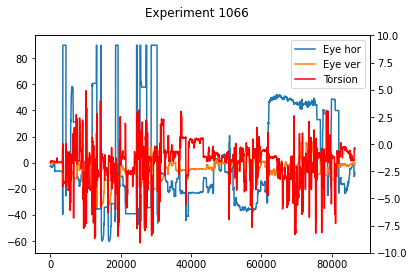

In [7]:
#Adding relative time column, removing Timestamp
for key in results.keys():
	results[key] = results[key].astype(dtype = 'float')
	start_val = results[key]['Timestamp'].min()
	results[key]['Time'] = (results[key]['Timestamp'] - start_val) / 10000
	results[key] = results[key].drop(labels='Timestamp', axis=1).set_index('Time')
	
	#Converting head values to a single quaternion and getting yaw
	q = results[key].loc[:, ['Head W', 'Head X', 'Head Y', 'Head Z']].values
	results[key]['roll'] = np.arctan2(2.0*(q[:,2]*q[:,3] + q[:,0]*q[:,1]), 1 - 2 * (q[:,1]**2 + q[:,2]**2)) 		/ pi * 180
	results[key]['yaw'] = np.arctan2(2.0*(q[:, 1]*q[:, 2] + q[:, 0]*q[:, 3]), -1 + 2 * (q[:, 0]**2 + q[:, 1]**2))	/ pi * 180
	results[key]['pitch'] = np.arcsin(2.0*(q[:, 0]*q[:, 2] - q[:, 1]*q[:, 3]))										/ pi * 180
	
	#results[key]['yaw'][results[key]['yaw'] < 0] += 360
	
for key, value in results.items():
	#value.loc[:, ['Eye hor','Eye ver', 'yaw']].plot(secondary_y='yaw')
	
	_, ax1 = plt.subplots()
	ax2 = ax1.twinx()
	ax2.set_ylim(bottom=-10, top=10)
	
	eh = ax1.plot(value.index, value['Eye hor'], label = 'Eye hor')
	ev = ax1.plot(value.index, value['Eye ver'], color = 'tab:orange', label = 'Eye ver')
	et = ax1.plot(value.index, value['Torsion'], color = '#FF0000', label = 'Torsion')
	#hy = ax2.plot(value.index, value['yaw'], color = 'tab:red', label = 'Head yaw')
	#hp = ax2.plot(value.index, value['pitch'], color = 'tab:blue', label = 'Head pitch')
	#hr = ax2.plot(value.index, value['roll'], color = 'tab:green', label = 'Head roll')
	
	#lns = hy+hp+hr
	#lns = eh+ev+hy+hp+hr+et
	lns = eh+ev+et
	labs = [l.get_label() for l in lns]
	plt.legend(lns, labs, loc='best')
	
	plt.xlabel = 'Time, miliseconds'
	plt.suptitle('Experiment ' + str(key))
	
plt.show()